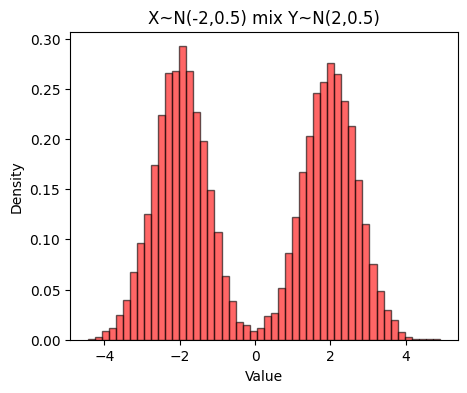

In [31]:
# Gaussian Mixture Model
# p(x) = sigma_{k=1}^{2}: pi_{k} * N(x|miu_k, sigma_k)
# pi1 = 0.5, N(x|miu=-2, sigma=0.5)
# pi2 = 0.5, N(x|miu=2, sigma=0.5)

import numpy as np
import matplotlib.pyplot as plt

# 量化到-10到10
def quantize_to_grid(x, low=-10, high=10, num_points=10000):
    grid = np.linspace(low, high, num_points)  # 在区间内均匀划分
    idx = np.abs(grid - x).argmin()            # 找到最接近的点索引
    return grid[idx]

N = 10000   # sample N个数据
XmixY = []
for i in range(N):
    if np.random.uniform(0,1) < 0.5:
        x = 2 + np.random.randn(1) * (0.5**0.5)
        x = quantize_to_grid(x)
        XmixY.append(x)
    else:
        y = -2 + np.random.randn(1) * (0.5**0.5)
        y = quantize_to_grid(y)
        XmixY.append(y)

XmixY = np.array(XmixY)

# 绘制直方图
plt.figure(figsize=(5,4))
plt.hist(XmixY, bins=50, density=True, color="red", alpha=0.6, edgecolor="black")
plt.title("X~N(-2,0.5) mix Y~N(2,0.5)")
plt.xlabel("Value")
plt.ylabel("Density")
plt.xlabel("Value")
plt.ylabel("Density")

plt.show()

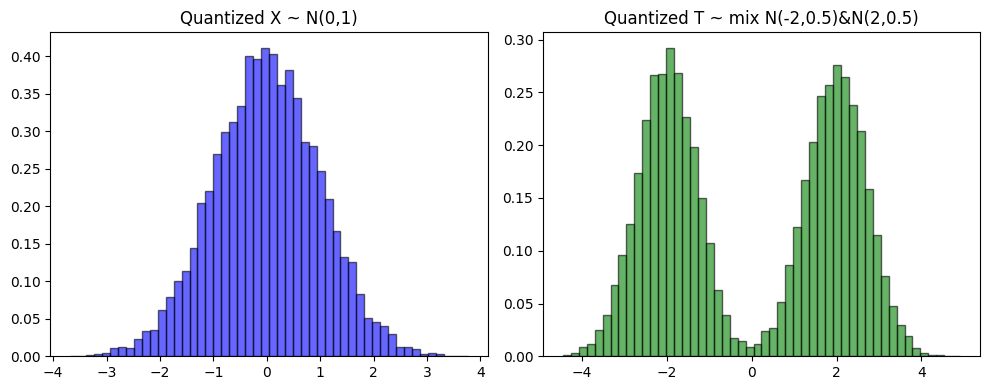

In [32]:
# target
T = XmixY

# input
X = []
for i in range(N):
    x = np.random.randn(1)
    x = quantize_to_grid(x)
    X.append(x)
X = np.array(X)

# 绘制直方图
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(X, bins=50, density=True, color="blue", alpha=0.6, edgecolor="black")
plt.title("Quantized X ~ N(0,1)")

plt.subplot(1,2,2)
plt.hist(T, bins=50, density=True, color="green", alpha=0.6, edgecolor="black")
plt.title("Quantized T ~ mix N(-2,0.5)&N(2,0.5)")

plt.tight_layout()
plt.show()

In [96]:
import torch
import torch.nn as nn
import torch.optim as optim

# 定义生成器 & 判别器
class Generator(nn.Module):
    def __init__(self, hidden_dim=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
    def forward(self, x):
        return self.net(x)

class Discriminator(nn.Module):
    def __init__(self, hidden_dim=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

G = Generator()
D = Discriminator()

lr = 1e-2
opt_G = optim.SGD(G.parameters(), lr=lr)
opt_D = optim.SGD(D.parameters(), lr=lr)
criterion = nn.BCELoss()


In [97]:
# 训练循环
epochs = 5000
batch_size = 1
losses_G, losses_D = [], []

T_tensor = torch.tensor(T, dtype=torch.float32).view(-1,1)
X_tensor = torch.tensor(X, dtype=torch.float32).view(-1,1)

best_loss_G = float("inf")
best_G_state, best_D_state = None, None

for epoch in range(epochs):
    idx = np.random.randint(0, N, batch_size)
    real_t = T_tensor[idx]
    # noise = torch.randn(batch_size, 1)  # 也可以替换成 X_tensor[idx]
    noise = X_tensor[idx]

    # ----------------------
    # 训练判别器
    # ----------------------
    fake_t = G(noise).detach()
    D_real = D(real_t)
    D_fake = D(fake_t)

    loss_D_real = criterion(D_real, torch.ones_like(D_real))
    loss_D_fake = criterion(D_fake, torch.zeros_like(D_fake))
    loss_D = (loss_D_real + loss_D_fake) / 2

    opt_D.zero_grad()
    loss_D.backward()
    opt_D.step()

    # ----------------------
    # 训练生成器
    # ----------------------
    noise = torch.randn(batch_size, 1)
    fake_t = G(noise)
    D_fake = D(fake_t)
    loss_G = criterion(D_fake, torch.ones_like(D_fake))  # 让判别器认为是真的

    opt_G.zero_grad()
    loss_G.backward()
    opt_G.step()

    # 记录损失
    losses_G.append(loss_G.item())
    losses_D.append(loss_D.item())

    # ----------------------
    # 保存最优模型
    # ----------------------
    if loss_G.item() < best_loss_G:
        best_loss_G = loss_G.item()
        best_G_state = G.state_dict()
        best_D_state = D.state_dict()

    if (epoch+1) % 200 == 0:
        print(f"Epoch [{epoch+1}/{epochs}]  Loss_D: {loss_D.item():.4f}, Loss_G: {loss_G.item():.4f}")

# ======================
# 保存最优权重
# ======================
torch.save(best_G_state, "../best_G.pth")
torch.save(best_D_state, "../best_D.pth")
print(f"Best models saved (best loss_G={best_loss_G:.4f})")

Epoch [200/5000]  Loss_D: 0.5991, Loss_G: 0.8163
Epoch [400/5000]  Loss_D: 0.3082, Loss_G: 1.0864
Epoch [600/5000]  Loss_D: 0.3102, Loss_G: 0.9792
Epoch [800/5000]  Loss_D: 0.2425, Loss_G: 0.9459
Epoch [1000/5000]  Loss_D: 0.5923, Loss_G: 0.0128
Epoch [1200/5000]  Loss_D: 0.6937, Loss_G: 0.6077
Epoch [1400/5000]  Loss_D: 0.5686, Loss_G: 0.6753
Epoch [1600/5000]  Loss_D: 0.6473, Loss_G: 0.6361
Epoch [1800/5000]  Loss_D: 0.7443, Loss_G: 0.8027
Epoch [2000/5000]  Loss_D: 0.7078, Loss_G: 0.8018
Epoch [2200/5000]  Loss_D: 0.5885, Loss_G: 0.8505
Epoch [2400/5000]  Loss_D: 0.7904, Loss_G: 0.6709
Epoch [2600/5000]  Loss_D: 0.6744, Loss_G: 0.5942
Epoch [2800/5000]  Loss_D: 0.6733, Loss_G: 0.6655
Epoch [3000/5000]  Loss_D: 0.6901, Loss_G: 0.9375
Epoch [3200/5000]  Loss_D: 0.6786, Loss_G: 0.6433
Epoch [3400/5000]  Loss_D: 0.7031, Loss_G: 0.8784
Epoch [3600/5000]  Loss_D: 0.8440, Loss_G: 0.9824
Epoch [3800/5000]  Loss_D: 0.6708, Loss_G: 0.7056
Epoch [4000/5000]  Loss_D: 0.6461, Loss_G: 0.6724
Epoc

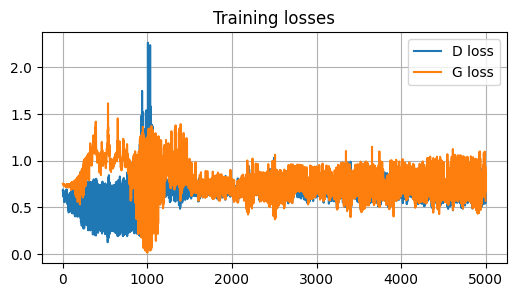

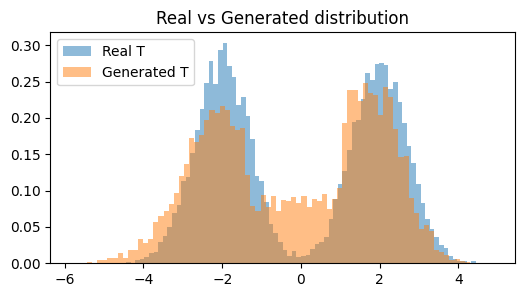

In [98]:
# 结果可视化
plt.figure(figsize=(6,3))
plt.plot(losses_D, label="D loss")
plt.plot(losses_G, label="G loss")
plt.legend(); plt.grid(); plt.title("Training losses")
plt.show()

# 生成器采样结果
with torch.no_grad():
    # noise = torch.randn(5000, 1)
    noise = torch.tensor(X, dtype=torch.float32).view(-1, 1)
    gen_samples = G(noise).numpy().flatten()

plt.figure(figsize=(6,3))
plt.hist(T, bins=80, density=True, alpha=0.5, label="Real T")
plt.hist(gen_samples, bins=80, density=True, alpha=0.5, label="Generated T")
plt.legend(); plt.title("Real vs Generated distribution")
plt.show()